In [2]:
# Prosody-driven stress clustering from phoneme-level alignments
# --------------------------------------------------------------
# Input: a list of dicts with fields: char, start, end, word, (optional) pitch
# Output: DataFrame with features per word + cluster label mapped to stressed/unstressed

from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --------------------------------------------------------------
# 1) Define phoneme classes and helper utilities
# --------------------------------------------------------------

# Broad vowel set covering ARPAbet + common IPA seen in your sample
VOWELS = set("""
AA AE AH AO AW AY EH ER EY IH IY OW OY UH UW
AA0 AA1 AA2 AE0 AE1 AE2 AH0 AH1 AH2 AO0 AO1 AO2 EH0 EH1 EH2 ER0 ER1 ER2
EY0 EY1 EY2 IH0 IH1 IH2 IY0 IY1 IY2 OW0 OW1 OW2 OY0 OY1 OY2 UH0 UH1 UH2 UW0 UW1 UW2
""".split())
# Add IPA-like symbols you have
VOWELS.update({"o", "ᵻ"})  # treat as vowels for duration/syllable heuristics

def is_vowel(ph):
    # Strip stress digits for ARPAbet (e.g., AH0 -> AH)
    base = ''.join([c for c in ph if not c.isdigit()])
    return base in VOWELS

def safe_pitch(p, t):
    # If pitch is missing, synthesize a monotonic surrogate (optional)
    if p is None:
        return 100.0 + 50.0 * float(t)
    return float(p)

# --------------------------------------------------------------
# 2) Core feature extraction per word
# --------------------------------------------------------------

def extract_word_features(phonemes):
    """
    phonemes: list of dicts with keys: char, start, end, word, (optional) pitch
    Returns: DataFrame with one row per word and engineered prosodic features.
    """
    if not phonemes:
        return pd.DataFrame()

    # Ensure pitch present
    for ph in phonemes:
        ph["pitch"] = safe_pitch(ph.get("pitch"), ph["start"])

    # Group by word while preserving order
    # (We also compute utterance-level context for normalization)
    utter_start = min(p["start"] for p in phonemes)
    utter_end   = max(p["end"] for p in phonemes)
    utter_dur   = max(1e-6, utter_end - utter_start)

    # Build word -> phoneme list
    word2ph = defaultdict(list)
    for p in phonemes:
        word2ph[p["word"]].append(p)

    # Construct word timeline order by first occurrence
    words_ordered = []
    seen = set()
    for p in phonemes:
        w = p["word"]
        if w not in seen:
            words_ordered.append(w)
            seen.add(w)

    # Compute start time per word to sort robustly
    words_ordered.sort(key=lambda w: min(pp["start"] for pp in word2ph[w]))

    # Pre-compute word start/end for pause features
    word_spans = []
    for w in words_ordered:
        starts = [pp["start"] for pp in word2ph[w]]
        ends   = [pp["end"] for pp in word2ph[w]]
        word_spans.append((w, min(starts), max(ends)))

    features = []
    for i, (w, w_start, w_end) in enumerate(word_spans):
        phs = word2ph[w]
        phs_sorted = sorted(phs, key=lambda p: p["start"])

        # Per-phoneme arrays
        starts = np.array([p["start"] for p in phs_sorted], dtype=float)
        ends   = np.array([p["end"]   for p in phs_sorted], dtype=float)
        durs   = ends - starts
        pitch  = np.array([p["pitch"] for p in phs_sorted], dtype=float)
        phones = [p["char"] for p in phs_sorted]

        # Vowel/consonant separation
        vowel_mask = np.array([is_vowel(ph) for ph in phones], dtype=bool)
        cons_mask  = ~vowel_mask

        # Core durations
        word_dur        = max(1e-6, w_end - w_start)
        vowel_dur       = float(durs[vowel_mask].sum()) if vowel_mask.any() else 0.0
        cons_dur        = float(durs[cons_mask].sum()) if cons_mask.any() else 0.0
        vowel_ratio     = vowel_dur / word_dur
        num_vowels      = int(vowel_mask.sum())
        num_phonemes    = len(phones)

        # Pitch features
        pitch_mean      = float(pitch.mean()) if len(pitch) else 0.0
        pitch_max       = float(pitch.max())  if len(pitch) else 0.0
        pitch_min       = float(pitch.min())  if len(pitch) else 0.0
        pitch_range     = pitch_max - pitch_min
        # Slope of pitch over the word (simple linear: last-first over duration)
        pitch_slope     = (pitch[-1] - pitch[0]) / word_dur if len(pitch) > 1 else 0.0
        # Pitch dynamics: std and mean absolute diff
        pitch_std       = float(pitch.std(ddof=0)) if len(pitch) > 1 else 0.0
        pitch_madiff    = float(np.mean(np.abs(np.diff(pitch)))) if len(pitch) > 1 else 0.0

        # Timing context
        # Pause before: gap from previous word end to this word start (>=0 else 0)
        pre_pause = 0.0
        if i > 0:
            prev_end = word_spans[i-1][2]
            pre_pause = max(0.0, w_start - prev_end)

        # Pause after
        post_pause = 0.0
        if i < len(word_spans)-1:
            next_start = word_spans[i+1][1]
            post_pause = max(0.0, next_start - w_end)

        # Position features
        pos_norm_start = (w_start - utter_start) / utter_dur
        pos_norm_center= ((w_start + w_end)/2 - utter_start) / utter_dur

        # Aggregate vowel-only pitch for prominence
        if vowel_mask.any():
            v_pitch = pitch[vowel_mask]
            v_mean  = float(v_pitch.mean())
            v_max   = float(v_pitch.max())
        else:
            v_mean = pitch_mean
            v_max  = pitch_max

        features.append(dict(
            word=w,
            word_start=w_start,
            word_end=w_end,
            word_duration=word_dur,
            num_phonemes=num_phonemes,
            num_vowels=num_vowels,
            vowel_duration=vowel_dur,
            consonant_duration=cons_dur,
            vowel_ratio=vowel_ratio,
            pitch_mean=pitch_mean,
            pitch_max=pitch_max,
            pitch_min=pitch_min,
            pitch_range=pitch_range,
            pitch_slope=pitch_slope,
            pitch_std=pitch_std,
            pitch_madiff=pitch_madiff,
            vowel_pitch_mean=v_mean,
            vowel_pitch_max=v_max,
            pre_pause=pre_pause,
            post_pause=post_pause,
            pos_norm_start=pos_norm_start,
            pos_norm_center=pos_norm_center
        ))

    df = pd.DataFrame(features)

    # Sentence-level normalization to derive prominence-ish indices
    for col in ["word_duration","vowel_duration","vowel_ratio","pitch_mean",
                "pitch_max","pitch_range","pitch_slope","pitch_std",
                "pitch_madiff","vowel_pitch_mean","vowel_pitch_max","pre_pause"]:
        mu = df[col].mean()
        sd = df[col].std(ddof=0) if df[col].std(ddof=0) > 1e-9 else 1.0
        df[f"{col}_z"] = (df[col] - mu) / sd

    # A simple prominence score (tunable): duration + pitch prominence + pre-pausal
    df["prominence_score"] = (
        0.5*df["vowel_duration_z"] +
        0.5*df["pitch_max_z"] +
        0.3*df["pitch_range_z"] +
        0.2*df["pitch_slope_z"] +
        0.3*df["pre_pause_z"]
    )

    return df.sort_values("word_start").reset_index(drop=True)

# --------------------------------------------------------------
# 3) Unsupervised clustering (KMeans) and mapping to labels
# --------------------------------------------------------------

def cluster_stress(df, k=2, random_state=42):
    """
    Clusters words into k=2 groups using prosodic features.
    Returns df with 'cluster' and 'stress_label' columns.
    """
    # Choose a robust feature set for clustering
    feature_cols = [
        # durations
        "word_duration","vowel_duration","vowel_ratio",
        # pitch levels/dynamics
        "pitch_mean","pitch_max","pitch_range","pitch_slope","pitch_std","pitch_madiff",
        "vowel_pitch_mean","vowel_pitch_max",
        # context
        "pre_pause","post_pause",
        # position to allow downweighting edge effects
        "pos_norm_start","pos_norm_center"
    ]
    X = df[feature_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    km = KMeans(n_clusters=k, n_init=20, random_state=random_state)
    df["cluster"] = km.fit_predict(X_scaled)

    # Heuristic mapping: the cluster with higher average prominence_score = "stressed"
    cluster_prom = df.groupby("cluster")["prominence_score"].mean().sort_values(ascending=False)
    stressed_cluster = cluster_prom.index[0]
    df["stress_label"] = np.where(df["cluster"] == stressed_cluster, "stressed", "unstressed")
    return df

# --------------------------------------------------------------
# 4) Example usage

# --------------------------------------------------------------

phonemes_input = [
   
    {"char": "IH", "start": 0.942, "end": 1.163, "word": "It", "pitch": 147.1},
    {"char": "ɾ", "start": 1.163, "end": 1.184, "word": "It", "pitch": 158.15},
    {"char": " ", "start": 1.184, "end": 1.325, "word": " ", "pitch": 159.2},

    {"char": "IH", "start": 1.325, "end": 1.345, "word": "is", "pitch": 166.25},
    {"char": "Z", "start": 1.345, "end": 1.425, "word": "is", "pitch": 167.25},
    {"char": " ", "start": 1.425, "end": 1.526, "word": " ", "pitch": 171.25},

    {"char": "AO", "start": 1.526, "end": 1.566, "word": "also", "pitch": 176.3},
    {"char": "L", "start": 1.566, "end": 1.626, "word": "also", "pitch": 178.3},
    {"char": "S", "start": 1.626, "end": 1.727, "word": "also", "pitch": 181.3},
    {"char": "o", "start": 1.727, "end": 1.888, "word": "also", "pitch": 186.35},
    {"char": "UH", "start": 1.888, "end": 1.908, "word": "also", "pitch": 194.4},
    {"char": " ", "start": 1.908, "end": 1.969, "word": " ", "pitch": 195.4},

    {"char": "P", "start": 1.969, "end": 1.989, "word": "plausible", "pitch": 198.45},
    {"char": "L", "start": 1.989, "end": 2.049, "word": "plausible", "pitch": 199.45},
    {"char": "AO", "start": 2.049, "end": 2.452, "word": "plausible", "pitch": 202.45},
    {"char": "Z", "start": 2.452, "end": 2.472, "word": "plausible", "pitch": 222.6},
    {"char": "ᵻ", "start": 2.472, "end": 2.492, "word": "plausible", "pitch": 223.6},
    {"char": "B", "start": 2.492, "end": 2.553, "word": "plausible", "pitch": 224.6},
    {"char": "AH0", "start": 2.553, "end": 3.156, "word": "plausible", "pitch": 227.65},
    {"char": "L", "start": 3.156, "end": 3.177, "word": "plausible", "pitch": 257.8},
    {"char": " ", "start": 3.177, "end": 3.197, "word": " ", "pitch": 258.85},

    {"char": "DH", "start": 3.197, "end": 3.217, "word": "that", "pitch": 259.85},
    {"char": "AE", "start": 3.217, "end": 3.398, "word": "that", "pitch": 260.85},
    {"char": "T", "start": 3.398, "end": 3.479, "word": "that", "pitch": 269.9},
    {"char": " ", "start": 3.479, "end": 3.781, "word": " ", "pitch": 274.95},

    {"char": "D", "start": 3.781, "end": 3.801, "word": "John", "pitch": 289.05},
    {"char": "ZH", "start": 3.801, "end": 3.821, "word": "John", "pitch": 290.05},
    {"char": "AA", "start": 3.821, "end": 3.901, "word": "John", "pitch": 291.05},
    {"char": "N", "start": 3.901, "end": 3.921, "word": "John", "pitch": 295.05},
    {"char": " ", "start": 3.921, "end": 3.942, "word": " ", "pitch": 296.05},

    {"char": "W", "start": 3.942, "end": 4.042, "word": "was", "pitch": 297.1},
    {"char": "AH", "start": 4.042, "end": 4.163, "word": "was", "pitch": 302.1},
    {"char": "Z", "start": 4.163, "end": 4.264, "word": "was", "pitch": 308.15},
    {"char": " ", "start": 4.264, "end": 4.385, "word": " ", "pitch": 313.2},

    {"char": "AO", "start": 4.385, "end": 4.425, "word": "already", "pitch": 319.25},
    {"char": "L", "start": 4.425, "end": 4.445, "word": "already", "pitch": 321.25},
    {"char": "R", "start": 4.445, "end": 4.525, "word": "already", "pitch": 322.25},
    {"char": "EH", "start": 4.525, "end": 4.686, "word": "already", "pitch": 326.25},
    {"char": "D", "start": 4.686, "end": 4.727, "word": "already", "pitch": 334.3},
    {"char": "IY", "start": 4.727, "end": 4.888, "word": "already", "pitch": 336.35},
    {"char": " ", "start": 4.888, "end": 5.129, "word": " ", "pitch": 344.4},

    {"char": "B", "start": 5.129, "end": 5.149, "word": "born", "pitch": 356.45},
    {"char": "AO", "start": 5.149, "end": 5.431, "word": "born", "pitch": 357.45},
    {"char": "R", "start": 5.431, "end": 5.451, "word": "born", "pitch": 371.55},
    {"char": "N", "start": 5.451, "end": 5.472, "word": "born", "pitch": 372.55},
    {"char": " ", "start": 5.472, "end": 5.492, "word": " ", "pitch": 373.6},

    {"char": "DH", "start": 5.492, "end": 5.512, "word": "there", "pitch": 374.6},
    {"char": "EH", "start": 5.512, "end": 5.532, "word": "there", "pitch": 375.6},
    {"char": "R", "start": 5.532, "end": 5.552, "word": "there", "pitch": 376.6}
]

# Remove spaces as "words" (optional but recommended for stress clustering)
phonemes = [p for p in phonemes_input if p["word"].strip() != ""]

# Run feature extraction
df_feats = extract_word_features(phonemes)

# Cluster and map to stress labels
df_out = cluster_stress(df_feats, k=2, random_state=7)

# Show the result
print(df_out[["word","word_start","word_end","word_duration",
              "vowel_duration","vowel_ratio",
              "pitch_mean","pitch_max","pitch_range",
              "pre_pause","prominence_score",
              "cluster","stress_label"]].to_string(index=False))


     word  word_start  word_end  word_duration  vowel_duration  vowel_ratio  pitch_mean  pitch_max  pitch_range  pre_pause  prominence_score  cluster stress_label
       It       0.942     1.184          0.242           0.221     0.913223  152.625000     158.15        11.05      0.000         -1.079413        1   unstressed
       is       1.325     1.425          0.100           0.020     0.200000  166.750000     167.25         1.00      0.141         -1.781032        1   unstressed
     also       1.526     1.908          0.382           0.221     0.578534  183.330000     194.40        18.10      0.101         -0.360553        1   unstressed
plausible       1.969     3.177          1.208           1.026     0.849338  219.575000     257.80        59.35      0.061          2.198759        1   unstressed
     that       3.197     3.479          0.282           0.181     0.641844  263.533333     269.90        10.05      0.020         -0.551100        0     stressed
     John       3.781 

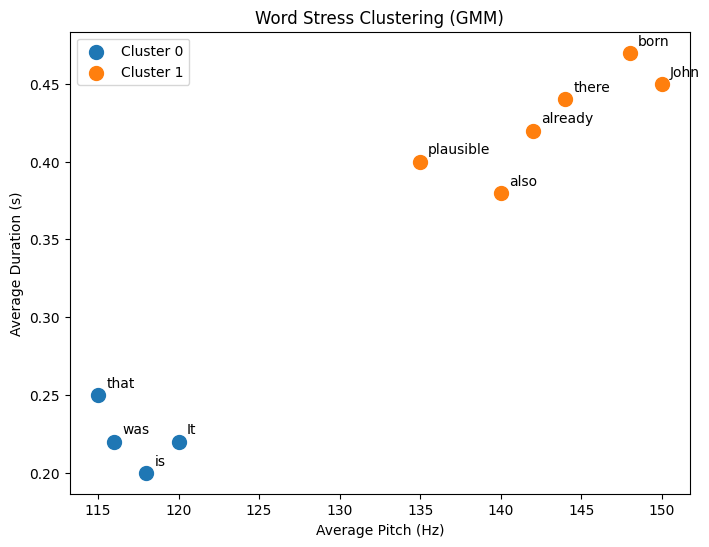

        word  avg_pitch  avg_duration  cluster
0         It        120          0.22        0
1         is        118          0.20        0
2       also        140          0.38        1
3  plausible        135          0.40        1
4       that        115          0.25        0
5       John        150          0.45        1
6        was        116          0.22        0
7    already        142          0.42        1
8       born        148          0.47        1
9      there        144          0.44        1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Example: phoneme-level data aggregated by word
# Replace this with your actual extracted features
# -----------------------------
data = [
    {"word": "It", "avg_pitch": 120, "avg_duration": 0.22},
    {"word": "is", "avg_pitch": 118, "avg_duration": 0.20},
    {"word": "also", "avg_pitch": 140, "avg_duration": 0.38},
    {"word": "plausible", "avg_pitch": 135, "avg_duration": 0.40},
    {"word": "that", "avg_pitch": 115, "avg_duration": 0.25},
    {"word": "John", "avg_pitch": 150, "avg_duration": 0.45},
    {"word": "was", "avg_pitch": 116, "avg_duration": 0.22},
    {"word": "already", "avg_pitch": 142, "avg_duration": 0.42},
    {"word": "born", "avg_pitch": 148, "avg_duration": 0.47},
    {"word": "there", "avg_pitch": 144, "avg_duration": 0.44},
]

df = pd.DataFrame(data)

# -----------------------------
# Feature scaling
# -----------------------------
X = df[["avg_pitch", "avg_duration"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Gaussian Mixture Model (2 clusters = stressed / unstressed)
# -----------------------------
gmm = GaussianMixture(n_components=2, random_state=42)
labels = gmm.fit_predict(X_scaled)
df["cluster"] = labels

# -----------------------------
# Plot clusters
# -----------------------------
plt.figure(figsize=(8,6))
for cluster in np.unique(labels):
    cluster_points = df[df["cluster"] == cluster]
    plt.scatter(cluster_points["avg_pitch"], 
                cluster_points["avg_duration"], 
                s=100, label=f"Cluster {cluster}")

# Annotate words
for i, row in df.iterrows():
    plt.text(row["avg_pitch"]+0.5, row["avg_duration"]+0.005, row["word"])

plt.xlabel("Average Pitch (Hz)")
plt.ylabel("Average Duration (s)")
plt.title("Word Stress Clustering (GMM)")
plt.legend()
plt.show()

print(df)


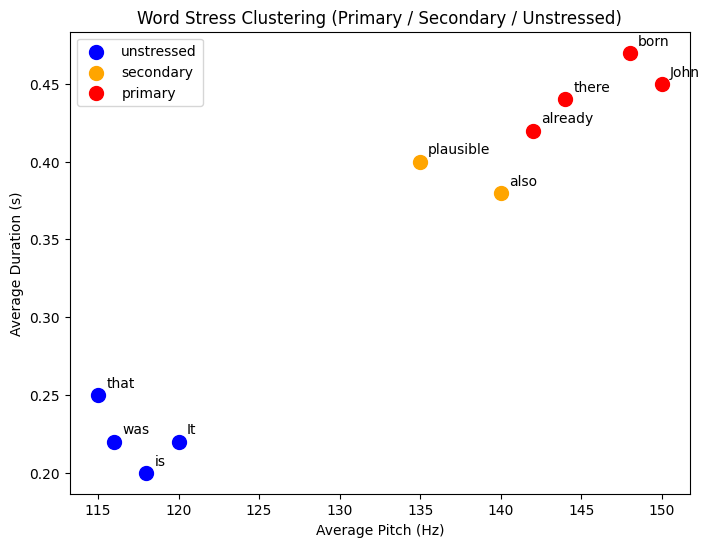

        word  avg_pitch  avg_duration      stress
0         It        120          0.22  unstressed
1         is        118          0.20  unstressed
2       also        140          0.38   secondary
3  plausible        135          0.40   secondary
4       that        115          0.25  unstressed
5       John        150          0.45     primary
6        was        116          0.22  unstressed
7    already        142          0.42     primary
8       born        148          0.47     primary
9      there        144          0.44     primary


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Example aggregated phoneme features per word
data = [
    {"word": "It", "avg_pitch": 120, "avg_duration": 0.22},
    {"word": "is", "avg_pitch": 118, "avg_duration": 0.20},
    {"word": "also", "avg_pitch": 140, "avg_duration": 0.38},
    {"word": "plausible", "avg_pitch": 135, "avg_duration": 0.40},
    {"word": "that", "avg_pitch": 115, "avg_duration": 0.25},
    {"word": "John", "avg_pitch": 150, "avg_duration": 0.45},
    {"word": "was", "avg_pitch": 116, "avg_duration": 0.22},
    {"word": "already", "avg_pitch": 142, "avg_duration": 0.42},
    {"word": "born", "avg_pitch": 148, "avg_duration": 0.47},
    {"word": "there", "avg_pitch": 144, "avg_duration": 0.44},
]

df = pd.DataFrame(data)

# -----------------------------
# Scale features
# -----------------------------
X = df[["avg_pitch", "avg_duration"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# GMM for 3 stress levels
# -----------------------------
gmm = GaussianMixture(n_components=3, random_state=42)
labels = gmm.fit_predict(X_scaled)
df["cluster"] = labels

# Rank clusters by average pitch (proxy for stress)
cluster_pitch = df.groupby("cluster")["avg_pitch"].mean().sort_values(ascending=False)
stress_map = {cluster: stress for cluster, stress in zip(cluster_pitch.index, ["primary", "secondary", "unstressed"])}
df["stress"] = df["cluster"].map(stress_map)

# -----------------------------
# Plot clusters
# -----------------------------
plt.figure(figsize=(8,6))
colors = {"primary":"red","secondary":"orange","unstressed":"blue"}

for stress_level in df["stress"].unique():
    points = df[df["stress"]==stress_level]
    plt.scatter(points["avg_pitch"], points["avg_duration"], 
                s=100, label=stress_level, color=colors[stress_level])

# Annotate words
for i, row in df.iterrows():
    plt.text(row["avg_pitch"]+0.5, row["avg_duration"]+0.005, row["word"])

plt.xlabel("Average Pitch (Hz)")
plt.ylabel("Average Duration (s)")
plt.title("Word Stress Clustering (Primary / Secondary / Unstressed)")
plt.legend()
plt.show()

print(df[["word","avg_pitch","avg_duration","stress"]])


/tmp/ipykernel_36/1377037516.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["stress"].fillna("noise/unstressed", inplace=True)


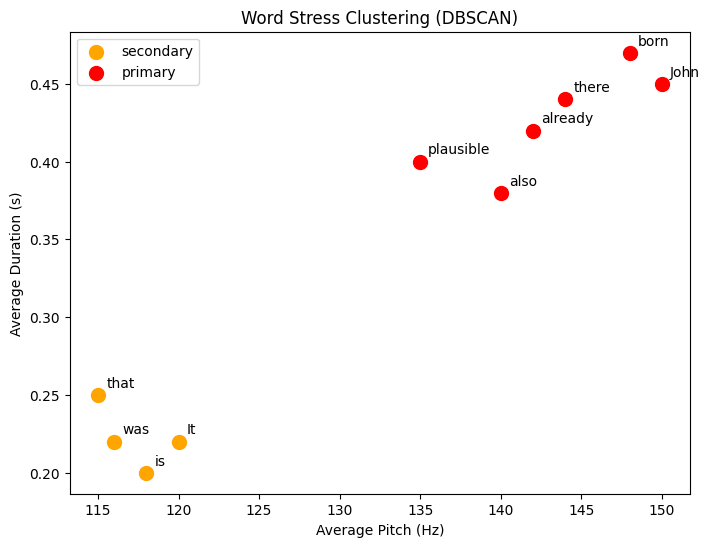

        word  avg_pitch  avg_duration  cluster     stress
0         It        120          0.22        0  secondary
1         is        118          0.20        0  secondary
2       also        140          0.38        1    primary
3  plausible        135          0.40        1    primary
4       that        115          0.25        0  secondary
5       John        150          0.45        1    primary
6        was        116          0.22        0  secondary
7    already        142          0.42        1    primary
8       born        148          0.47        1    primary
9      there        144          0.44        1    primary


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# -----------------------------
# Example aggregated phoneme features per word
# -----------------------------
data = [
    {"word": "It", "avg_pitch": 120, "avg_duration": 0.22},
    {"word": "is", "avg_pitch": 118, "avg_duration": 0.20},
    {"word": "also", "avg_pitch": 140, "avg_duration": 0.38},
    {"word": "plausible", "avg_pitch": 135, "avg_duration": 0.40},
    {"word": "that", "avg_pitch": 115, "avg_duration": 0.25},
    {"word": "John", "avg_pitch": 150, "avg_duration": 0.45},
    {"word": "was", "avg_pitch": 116, "avg_duration": 0.22},
    {"word": "already", "avg_pitch": 142, "avg_duration": 0.42},
    {"word": "born", "avg_pitch": 148, "avg_duration": 0.47},
    {"word": "there", "avg_pitch": 144, "avg_duration": 0.44},
]

df = pd.DataFrame(data)

# -----------------------------
# Scale features
# -----------------------------
X = df[["avg_pitch", "avg_duration"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# DBSCAN clustering
# -----------------------------
dbscan = DBSCAN(eps=0.5, min_samples=3)  # eps may need tuning
labels = dbscan.fit_predict(X_scaled)
df["cluster"] = labels

# -----------------------------
# Map clusters to stress level
# DBSCAN labels -1 are noise
# -----------------------------
unique_clusters = [c for c in np.unique(labels) if c != -1]
cluster_pitch = df[df["cluster"]!=-1].groupby("cluster")["avg_pitch"].mean().sort_values(ascending=False)
stress_levels = ["primary", "secondary", "unstressed"][:len(unique_clusters)]
stress_map = {cluster: stress for cluster, stress in zip(cluster_pitch.index, stress_levels)}
df["stress"] = df["cluster"].map(stress_map)
df["stress"].fillna("noise/unstressed", inplace=True)

# -----------------------------
# Plot clusters
# -----------------------------
plt.figure(figsize=(8,6))
colors = {"primary":"red","secondary":"orange","unstressed":"blue","noise/unstressed":"gray"}

for stress_level in df["stress"].unique():
    points = df[df["stress"]==stress_level]
    plt.scatter(points["avg_pitch"], points["avg_duration"], 
                s=100, label=stress_level, color=colors[stress_level])

# Annotate words
for i, row in df.iterrows():
    plt.text(row["avg_pitch"]+0.5, row["avg_duration"]+0.005, row["word"])

plt.xlabel("Average Pitch (Hz)")
plt.ylabel("Average Duration (s)")
plt.title("Word Stress Clustering (DBSCAN)")
plt.legend()
plt.show()

print(df[["word","avg_pitch","avg_duration","cluster","stress"]])


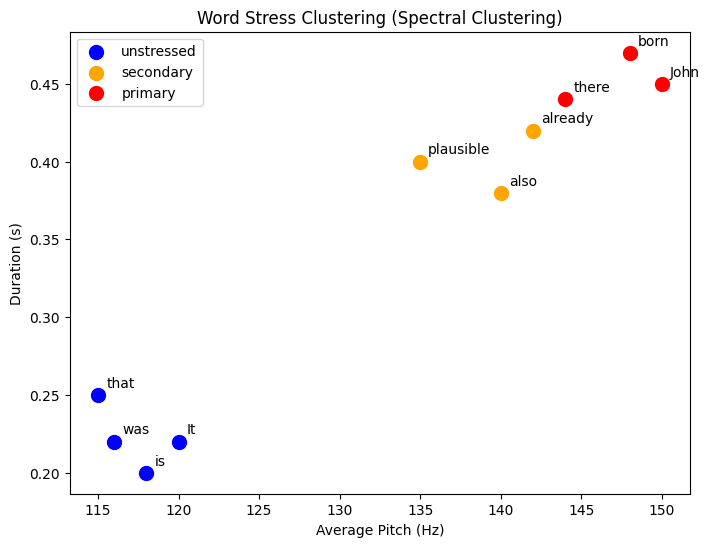

        word  avg_pitch  duration  syllables  cluster      stress
0         It        120      0.22          1        2  unstressed
1         is        118      0.20          1        2  unstressed
2       also        140      0.38          2        1   secondary
3  plausible        135      0.40          3        1   secondary
4       that        115      0.25          1        2  unstressed
5       John        150      0.45          1        0     primary
6        was        116      0.22          1        2  unstressed
7    already        142      0.42          3        1   secondary
8       born        148      0.47          1        0     primary
9      there        144      0.44          1        0     primary


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering

# -----------------------------
# Example word-level prosodic dataset
# -----------------------------
data = [
    {"word": "It", "avg_pitch": 120, "duration": 0.22, "syllables": 1},
    {"word": "is", "avg_pitch": 118, "duration": 0.20, "syllables": 1},
    {"word": "also", "avg_pitch": 140, "duration": 0.38, "syllables": 2},
    {"word": "plausible", "avg_pitch": 135, "duration": 0.40, "syllables": 3},
    {"word": "that", "avg_pitch": 115, "duration": 0.25, "syllables": 1},
    {"word": "John", "avg_pitch": 150, "duration": 0.45, "syllables": 1},
    {"word": "was", "avg_pitch": 116, "duration": 0.22, "syllables": 1},
    {"word": "already", "avg_pitch": 142, "duration": 0.42, "syllables": 3},
    {"word": "born", "avg_pitch": 148, "duration": 0.47, "syllables": 1},
    {"word": "there", "avg_pitch": 144, "duration": 0.44, "syllables": 1},
]

df = pd.DataFrame(data)

# -----------------------------
# Feature matrix
# -----------------------------
X = df[["avg_pitch", "duration", "syllables"]].values

# Scale features for better clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Spectral Clustering
# -----------------------------
n_clusters = 3  # Primary, Secondary, Unstressed
spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', assign_labels='kmeans', random_state=42)
labels = spectral.fit_predict(X_scaled)
df["cluster"] = labels

# -----------------------------
# Map clusters to stress levels
# Assign 'primary' to cluster with highest average pitch,
# 'secondary' to medium pitch, 'unstressed' to lowest pitch
# -----------------------------
cluster_avg_pitch = df.groupby("cluster")["avg_pitch"].mean().sort_values(ascending=False)
stress_levels = ["primary", "secondary", "unstressed"][:len(cluster_avg_pitch)]
stress_map = {cluster: stress for cluster, stress in zip(cluster_avg_pitch.index, stress_levels)}
df["stress"] = df["cluster"].map(stress_map)

# -----------------------------
# Plot clusters
# -----------------------------
plt.figure(figsize=(8,6))
colors = {"primary":"red","secondary":"orange","unstressed":"blue"}

for stress_level in df["stress"].unique():
    points = df[df["stress"]==stress_level]
    plt.scatter(points["avg_pitch"], points["duration"], 
                s=100, label=stress_level, color=colors[stress_level])

# Annotate words
for i, row in df.iterrows():
    plt.text(row["avg_pitch"]+0.5, row["duration"]+0.005, row["word"])

plt.xlabel("Average Pitch (Hz)")
plt.ylabel("Duration (s)")
plt.title("Word Stress Clustering (Spectral Clustering)")
plt.legend()
plt.show()

# -----------------------------
# Display final DataFrame
# -----------------------------
print(df[["word","avg_pitch","duration","syllables","cluster","stress"]])


[nltk_data] Downloading package cmudict to /usr/share/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


   primary_ratio  secondary_ratio  unstressed_ratio  syllables       word
0       1.000000              0.0          0.000000          1         It
1       1.000000              0.0          0.000000          1         is
2       0.500000              0.0          0.500000          2       also
3       0.333333              0.0          0.666667          3  plausible
4       1.000000              0.0          0.000000          1       that
5       1.000000              0.0          0.000000          1       John
6       1.000000              0.0          0.000000          1        was
7       0.333333              0.0          0.666667          3    already
8       1.000000              0.0          0.000000          1       born
9       1.000000              0.0          0.000000          1      there
        word  syllables  primary_ratio  secondary_ratio  unstressed_ratio  \
0         It          1       1.000000              0.0          0.000000   
1         is          1       1.

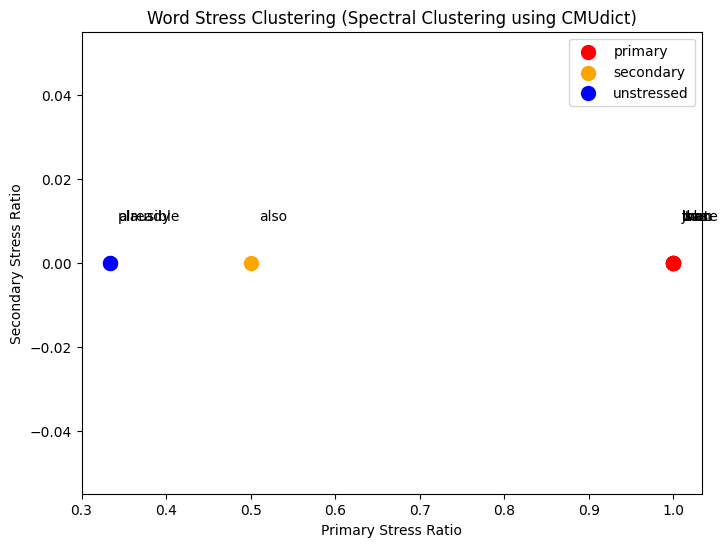

In [7]:
import nltk
from nltk.corpus import cmudict
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Download CMU dictionary if not already
nltk.download('cmudict')
cmu = cmudict.dict()

# Example sentence
sentence = ["It", "is", "also", "plausible", "that", "John", "was", "already", "born", "there"]

# Function to extract stress features
def get_stress_features(word):
    word_lower = word.lower()
    if word_lower not in cmu:
        return {"primary":0, "secondary":0, "unstressed":0, "syllables":1}  # fallback
    # Take the first pronunciation
    pron = cmu[word_lower][0]
    primary = sum(1 for ph in pron if ph[-1:]=="1")
    secondary = sum(1 for ph in pron if ph[-1:]=="2")
    unstressed = sum(1 for ph in pron if ph[-1:]=="0")
    syllables = primary + secondary + unstressed
    # Ratios
    return {
        "primary_ratio": primary/syllables if syllables>0 else 0,
        "secondary_ratio": secondary/syllables if syllables>0 else 0,
        "unstressed_ratio": unstressed/syllables if syllables>0 else 1,
        "syllables": syllables
    }

# Build feature dataframe
features = []
for word in sentence:
    f = get_stress_features(word)
    f["word"] = word
    features.append(f)

df = pd.DataFrame(features)
print(df)

# Feature matrix
X = df[["primary_ratio","secondary_ratio","unstressed_ratio","syllables"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Spectral Clustering
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', assign_labels='kmeans', random_state=42)
labels = spectral.fit_predict(X_scaled)
df["cluster"] = labels

# Map clusters to stress levels based on average primary_ratio
cluster_primary = df.groupby("cluster")["primary_ratio"].mean().sort_values(ascending=False)
stress_levels = ["primary","secondary","unstressed"]
stress_map = {cluster: stress for cluster, stress in zip(cluster_primary.index, stress_levels)}
df["stress"] = df["cluster"].map(stress_map)

print(df[["word","syllables","primary_ratio","secondary_ratio","unstressed_ratio","cluster","stress"]])

# Plot clusters
plt.figure(figsize=(8,6))
colors = {"primary":"red","secondary":"orange","unstressed":"blue"}

for stress_level in df["stress"].unique():
    points = df[df["stress"]==stress_level]
    plt.scatter(points["primary_ratio"], points["secondary_ratio"], 
                s=100, label=stress_level, color=colors[stress_level])
    for i, row in points.iterrows():
        plt.text(row["primary_ratio"]+0.01, row["secondary_ratio"]+0.01, row["word"])

plt.xlabel("Primary Stress Ratio")
plt.ylabel("Secondary Stress Ratio")
plt.title("Word Stress Clustering (Spectral Clustering using CMUdict)")
plt.legend()
plt.show()


        word  duration  mean_pitch  std_pitch  num_vowels  num_consonants  \
0         It     0.242  152.625000   7.813530           1               1   
1       John     0.140  291.300000   2.629956           1               3   
2    already     0.503  326.608333   7.156006           3               3   
3       also     0.382  183.330000   7.254447           2               3   
4       born     0.343  364.500000   8.737086           1               3   
5         is     0.100  166.750000   0.707107           1               1   
6  plausible     1.208  219.575000  19.717668           2               6   
7       that     0.282  263.533333   5.536319           1               2   
8      there     0.060  375.600000   1.000000           1               2   
9        was     0.322  302.450000   5.533308           1               2   

   syllable_ratio  
0        0.500000  
1        0.250000  
2        0.500000  
3        0.400000  
4        0.250000  
5        0.500000  
6        0.2

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


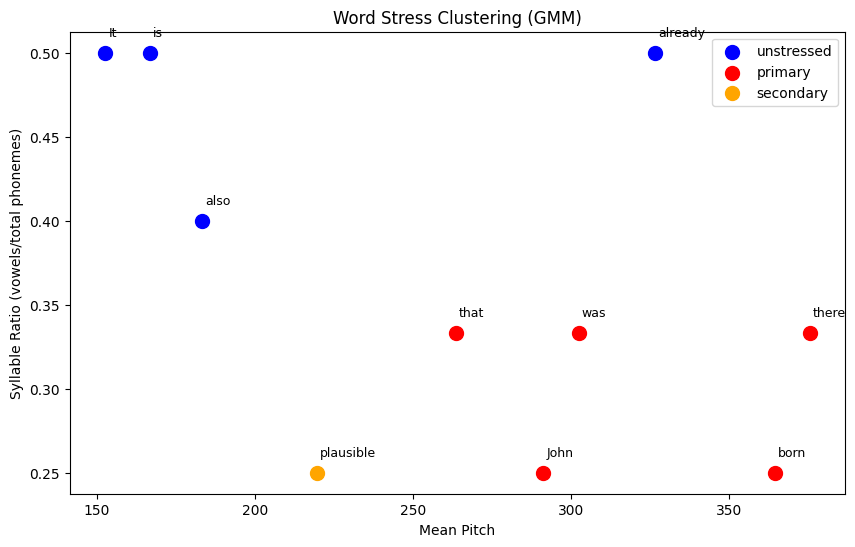

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Your phoneme-level data
phonemes_input = [
    # Paste your phoneme dicts here. Example (shortened):
    {"char": "IH", "start": 0.942, "end": 1.163, "word": "It", "pitch": 147.1},
    {"char": "ɾ", "start": 1.163, "end": 1.184, "word": "It", "pitch": 158.15},
    {"char": " ", "start": 1.184, "end": 1.325, "word": " ", "pitch": 159.2},

    {"char": "IH", "start": 1.325, "end": 1.345, "word": "is", "pitch": 166.25},
    {"char": "Z", "start": 1.345, "end": 1.425, "word": "is", "pitch": 167.25},
    {"char": " ", "start": 1.425, "end": 1.526, "word": " ", "pitch": 171.25},

    {"char": "AO", "start": 1.526, "end": 1.566, "word": "also", "pitch": 176.3},
    {"char": "L", "start": 1.566, "end": 1.626, "word": "also", "pitch": 178.3},
    {"char": "S", "start": 1.626, "end": 1.727, "word": "also", "pitch": 181.3},
    {"char": "o", "start": 1.727, "end": 1.888, "word": "also", "pitch": 186.35},
    {"char": "UH", "start": 1.888, "end": 1.908, "word": "also", "pitch": 194.4},
    {"char": " ", "start": 1.908, "end": 1.969, "word": " ", "pitch": 195.4},

    {"char": "P", "start": 1.969, "end": 1.989, "word": "plausible", "pitch": 198.45},
    {"char": "L", "start": 1.989, "end": 2.049, "word": "plausible", "pitch": 199.45},
    {"char": "AO", "start": 2.049, "end": 2.452, "word": "plausible", "pitch": 202.45},
    {"char": "Z", "start": 2.452, "end": 2.472, "word": "plausible", "pitch": 222.6},
    {"char": "ᵻ", "start": 2.472, "end": 2.492, "word": "plausible", "pitch": 223.6},
    {"char": "B", "start": 2.492, "end": 2.553, "word": "plausible", "pitch": 224.6},
    {"char": "AH0", "start": 2.553, "end": 3.156, "word": "plausible", "pitch": 227.65},
    {"char": "L", "start": 3.156, "end": 3.177, "word": "plausible", "pitch": 257.8},
    {"char": " ", "start": 3.177, "end": 3.197, "word": " ", "pitch": 258.85},

    {"char": "DH", "start": 3.197, "end": 3.217, "word": "that", "pitch": 259.85},
    {"char": "AE", "start": 3.217, "end": 3.398, "word": "that", "pitch": 260.85},
    {"char": "T", "start": 3.398, "end": 3.479, "word": "that", "pitch": 269.9},
    {"char": " ", "start": 3.479, "end": 3.781, "word": " ", "pitch": 274.95},

    {"char": "D", "start": 3.781, "end": 3.801, "word": "John", "pitch": 289.05},
    {"char": "ZH", "start": 3.801, "end": 3.821, "word": "John", "pitch": 290.05},
    {"char": "AA", "start": 3.821, "end": 3.901, "word": "John", "pitch": 291.05},
    {"char": "N", "start": 3.901, "end": 3.921, "word": "John", "pitch": 295.05},
    {"char": " ", "start": 3.921, "end": 3.942, "word": " ", "pitch": 296.05},

    {"char": "W", "start": 3.942, "end": 4.042, "word": "was", "pitch": 297.1},
    {"char": "AH", "start": 4.042, "end": 4.163, "word": "was", "pitch": 302.1},
    {"char": "Z", "start": 4.163, "end": 4.264, "word": "was", "pitch": 308.15},
    {"char": " ", "start": 4.264, "end": 4.385, "word": " ", "pitch": 313.2},

    {"char": "AO", "start": 4.385, "end": 4.425, "word": "already", "pitch": 319.25},
    {"char": "L", "start": 4.425, "end": 4.445, "word": "already", "pitch": 321.25},
    {"char": "R", "start": 4.445, "end": 4.525, "word": "already", "pitch": 322.25},
    {"char": "EH", "start": 4.525, "end": 4.686, "word": "already", "pitch": 326.25},
    {"char": "D", "start": 4.686, "end": 4.727, "word": "already", "pitch": 334.3},
    {"char": "IY", "start": 4.727, "end": 4.888, "word": "already", "pitch": 336.35},
    {"char": " ", "start": 4.888, "end": 5.129, "word": " ", "pitch": 344.4},

    {"char": "B", "start": 5.129, "end": 5.149, "word": "born", "pitch": 356.45},
    {"char": "AO", "start": 5.149, "end": 5.431, "word": "born", "pitch": 357.45},
    {"char": "R", "start": 5.431, "end": 5.451, "word": "born", "pitch": 371.55},
    {"char": "N", "start": 5.451, "end": 5.472, "word": "born", "pitch": 372.55},
    {"char": " ", "start": 5.472, "end": 5.492, "word": " ", "pitch": 373.6},

    {"char": "DH", "start": 5.492, "end": 5.512, "word": "there", "pitch": 374.6},
    {"char": "EH", "start": 5.512, "end": 5.532, "word": "there", "pitch": 375.6},
    {"char": "R", "start": 5.532, "end": 5.552, "word": "there", "pitch": 376.6}
]

# Convert to DataFrame
df_phon = pd.DataFrame(phonemes_input)

# Identify vowels in ARPAbet (CMU style)
vowels = ["AA","AE","AH","AO","AW","AY","EH","ER","EY","IH","IY","OW","OY","UH","UW","AH0","AH1","AH2","AO0","AO1","AO2","EH0","EH1","EH2","IH0","IH1","IH2","UH0","UH1","UH2","IY0","IY1","IY2","AO"]

# Aggregate features per word
word_features = []
for word, group in df_phon.groupby("word"):
    if word.strip() == "":
        continue
    duration = group["end"].max() - group["start"].min()
    mean_pitch = group["pitch"].mean()
    std_pitch = group["pitch"].std()
    num_vowels = sum([1 for ph in group["char"] if ph in vowels])
    num_consonants = sum([1 for ph in group["char"] if ph not in vowels and ph != " "])
    syllable_ratio = num_vowels / (num_vowels + num_consonants) if (num_vowels + num_consonants) > 0 else 0
    word_features.append({
        "word": word,
        "duration": duration,
        "mean_pitch": mean_pitch,
        "std_pitch": std_pitch,
        "num_vowels": num_vowels,
        "num_consonants": num_consonants,
        "syllable_ratio": syllable_ratio
    })

df_words = pd.DataFrame(word_features)
print(df_words)

# Prepare feature matrix
features = ["duration","mean_pitch","std_pitch","num_vowels","num_consonants","syllable_ratio"]
X = df_words[features].values
X_scaled = StandardScaler().fit_transform(X)

# --- Clustering using GMM ---
n_clusters = 3  # Primary / Secondary / Unstressed
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)
df_words["cluster_gmm"] = labels_gmm

# --- Clustering using KMeans (alternative) ---
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
df_words["cluster_kmeans"] = labels_kmeans

# Map clusters to stress based on mean_pitch or syllable_ratio (simple heuristic)
cluster_map = df_words.groupby("cluster_gmm")["mean_pitch"].mean().sort_values(ascending=False).to_dict()
stress_levels = ["primary","secondary","unstressed"]
stress_map = {cluster: stress for cluster, stress in zip(cluster_map.keys(), stress_levels)}
df_words["stress_gmm"] = df_words["cluster_gmm"].map(stress_map)

print(df_words)

# --- Plot clusters ---
plt.figure(figsize=(10,6))
colors = {"primary":"red","secondary":"orange","unstressed":"blue"}
for stress_level in df_words["stress_gmm"].unique():
    subset = df_words[df_words["stress_gmm"]==stress_level]
    plt.scatter(subset["mean_pitch"], subset["syllable_ratio"], s=100, label=stress_level, color=colors[stress_level])
    for i, row in subset.iterrows():
        plt.text(row["mean_pitch"]+1, row["syllable_ratio"]+0.01, row["word"], fontsize=9)
plt.xlabel("Mean Pitch")
plt.ylabel("Syllable Ratio (vowels/total phonemes)")
plt.title("Word Stress Clustering (GMM)")
plt.legend()
plt.show()


[nltk_data] Downloading package cmudict to /usr/share/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


        word  duration  mean_pitch  std_pitch  num_vowels  num_consonants  \
0         It     0.242  152.625000   7.813530           1               1   
1       John     0.140  291.300000   2.629956           1               3   
2    already     0.503  326.608333   7.156006           3               3   
3       also     0.382  183.330000   7.254447           2               3   
4       born     0.343  364.500000   8.737086           1               3   
5         is     0.100  166.750000   0.707107           1               1   
6  plausible     1.208  219.575000  19.717668           1               7   
7       that     0.282  263.533333   5.536319           1               2   
8      there     0.060  375.600000   1.000000           1               2   
9        was     0.322  302.450000   5.533308           1               2   

   syllable_ratio  cmu_stress  
0        0.500000           1  
1        0.250000           1  
2        0.500000           0  
3        0.400000       

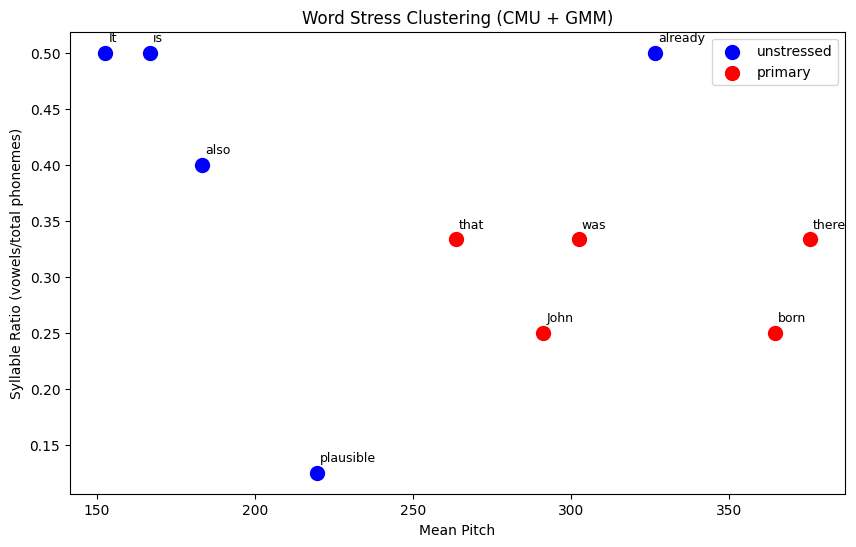

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import nltk

# Download CMU dictionary if not already
nltk.download('cmudict')
from nltk.corpus import cmudict

cmu_dict = cmudict.dict()

phonemes_input = [
    # Paste your phoneme dicts here. Example (shortened):
    {"char": "IH", "start": 0.942, "end": 1.163, "word": "It", "pitch": 147.1},
    {"char": "ɾ", "start": 1.163, "end": 1.184, "word": "It", "pitch": 158.15},
    {"char": " ", "start": 1.184, "end": 1.325, "word": " ", "pitch": 159.2},

    {"char": "IH", "start": 1.325, "end": 1.345, "word": "is", "pitch": 166.25},
    {"char": "Z", "start": 1.345, "end": 1.425, "word": "is", "pitch": 167.25},
    {"char": " ", "start": 1.425, "end": 1.526, "word": " ", "pitch": 171.25},

    {"char": "AO", "start": 1.526, "end": 1.566, "word": "also", "pitch": 176.3},
    {"char": "L", "start": 1.566, "end": 1.626, "word": "also", "pitch": 178.3},
    {"char": "S", "start": 1.626, "end": 1.727, "word": "also", "pitch": 181.3},
    {"char": "o", "start": 1.727, "end": 1.888, "word": "also", "pitch": 186.35},
    {"char": "UH", "start": 1.888, "end": 1.908, "word": "also", "pitch": 194.4},
    {"char": " ", "start": 1.908, "end": 1.969, "word": " ", "pitch": 195.4},

    {"char": "P", "start": 1.969, "end": 1.989, "word": "plausible", "pitch": 198.45},
    {"char": "L", "start": 1.989, "end": 2.049, "word": "plausible", "pitch": 199.45},
    {"char": "AO", "start": 2.049, "end": 2.452, "word": "plausible", "pitch": 202.45},
    {"char": "Z", "start": 2.452, "end": 2.472, "word": "plausible", "pitch": 222.6},
    {"char": "ᵻ", "start": 2.472, "end": 2.492, "word": "plausible", "pitch": 223.6},
    {"char": "B", "start": 2.492, "end": 2.553, "word": "plausible", "pitch": 224.6},
    {"char": "AH0", "start": 2.553, "end": 3.156, "word": "plausible", "pitch": 227.65},
    {"char": "L", "start": 3.156, "end": 3.177, "word": "plausible", "pitch": 257.8},
    {"char": " ", "start": 3.177, "end": 3.197, "word": " ", "pitch": 258.85},

    {"char": "DH", "start": 3.197, "end": 3.217, "word": "that", "pitch": 259.85},
    {"char": "AE", "start": 3.217, "end": 3.398, "word": "that", "pitch": 260.85},
    {"char": "T", "start": 3.398, "end": 3.479, "word": "that", "pitch": 269.9},
    {"char": " ", "start": 3.479, "end": 3.781, "word": " ", "pitch": 274.95},

    {"char": "D", "start": 3.781, "end": 3.801, "word": "John", "pitch": 289.05},
    {"char": "ZH", "start": 3.801, "end": 3.821, "word": "John", "pitch": 290.05},
    {"char": "AA", "start": 3.821, "end": 3.901, "word": "John", "pitch": 291.05},
    {"char": "N", "start": 3.901, "end": 3.921, "word": "John", "pitch": 295.05},
    {"char": " ", "start": 3.921, "end": 3.942, "word": " ", "pitch": 296.05},

    {"char": "W", "start": 3.942, "end": 4.042, "word": "was", "pitch": 297.1},
    {"char": "AH", "start": 4.042, "end": 4.163, "word": "was", "pitch": 302.1},
    {"char": "Z", "start": 4.163, "end": 4.264, "word": "was", "pitch": 308.15},
    {"char": " ", "start": 4.264, "end": 4.385, "word": " ", "pitch": 313.2},

    {"char": "AO", "start": 4.385, "end": 4.425, "word": "already", "pitch": 319.25},
    {"char": "L", "start": 4.425, "end": 4.445, "word": "already", "pitch": 321.25},
    {"char": "R", "start": 4.445, "end": 4.525, "word": "already", "pitch": 322.25},
    {"char": "EH", "start": 4.525, "end": 4.686, "word": "already", "pitch": 326.25},
    {"char": "D", "start": 4.686, "end": 4.727, "word": "already", "pitch": 334.3},
    {"char": "IY", "start": 4.727, "end": 4.888, "word": "already", "pitch": 336.35},
    {"char": " ", "start": 4.888, "end": 5.129, "word": " ", "pitch": 344.4},

    {"char": "B", "start": 5.129, "end": 5.149, "word": "born", "pitch": 356.45},
    {"char": "AO", "start": 5.149, "end": 5.431, "word": "born", "pitch": 357.45},
    {"char": "R", "start": 5.431, "end": 5.451, "word": "born", "pitch": 371.55},
    {"char": "N", "start": 5.451, "end": 5.472, "word": "born", "pitch": 372.55},
    {"char": " ", "start": 5.472, "end": 5.492, "word": " ", "pitch": 373.6},

    {"char": "DH", "start": 5.492, "end": 5.512, "word": "there", "pitch": 374.6},
    {"char": "EH", "start": 5.512, "end": 5.532, "word": "there", "pitch": 375.6},
    {"char": "R", "start": 5.532, "end": 5.552, "word": "there", "pitch": 376.6}
]
df_phon = pd.DataFrame(phonemes_input)

# Helper: identify vowels and stress in CMU format
vowels = ["AA","AE","AH","AO","AW","AY","EH","ER","EY","IH","IY","OW","OY","UH","UW"]

def get_cmu_stress(word):
    """Return list of stress markers for CMU pronunciation of a word."""
    word = word.lower()
    if word not in cmu_dict:
        return []
    pron = cmu_dict[word][0]  # take first pronunciation
    stress_marks = []
    for ph in pron:
        for v in vowels:
            if ph.startswith(v):
                # last char of phoneme can be stress marker 0,1,2
                if ph[-1] in ['0','1','2']:
                    stress_marks.append(int(ph[-1]))
                else:
                    stress_marks.append(0)
    return stress_marks

# Aggregate word-level features
word_features = []
for word, group in df_phon.groupby("word"):
    if word.strip() == "":
        continue
    duration = group["end"].max() - group["start"].min()
    mean_pitch = group["pitch"].mean()
    std_pitch = group["pitch"].std()
    num_vowels = sum([1 for ph in group["char"] if ph in vowels])
    num_consonants = sum([1 for ph in group["char"] if ph not in vowels and ph != " "])
    syllable_ratio = num_vowels / (num_vowels + num_consonants) if (num_vowels + num_consonants) > 0 else 0
    stress_cmu = get_cmu_stress(word)
    # Most frequent stress in the word
    stress_label = max(set(stress_cmu), key=stress_cmu.count) if stress_cmu else -1
    word_features.append({
        "word": word,
        "duration": duration,
        "mean_pitch": mean_pitch,
        "std_pitch": std_pitch,
        "num_vowels": num_vowels,
        "num_consonants": num_consonants,
        "syllable_ratio": syllable_ratio,
        "cmu_stress": stress_label
    })

df_words = pd.DataFrame(word_features)
print(df_words)

# Feature matrix
features = ["duration","mean_pitch","std_pitch","num_vowels","num_consonants","syllable_ratio"]
X = df_words[features].values
X_scaled = StandardScaler().fit_transform(X)

# --- GMM clustering ---
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)
df_words["cluster_gmm"] = labels_gmm

# Map cluster to primary/secondary/unstressed using majority CMU stress
stress_map = {}
for cluster in range(n_clusters):
    subset = df_words[df_words["cluster_gmm"]==cluster]
    most_common_stress = subset["cmu_stress"].mode()[0] if not subset.empty else -1
    if most_common_stress == 1:
        stress_map[cluster] = "primary"
    elif most_common_stress == 2:
        stress_map[cluster] = "secondary"
    else:
        stress_map[cluster] = "unstressed"

df_words["stress_gmm"] = df_words["cluster_gmm"].map(stress_map)
print(df_words)

# --- Plot clusters ---
plt.figure(figsize=(10,6))
colors = {"primary":"red","secondary":"orange","unstressed":"blue"}
for stress_level in df_words["stress_gmm"].unique():
    subset = df_words[df_words["stress_gmm"]==stress_level]
    plt.scatter(subset["mean_pitch"], subset["syllable_ratio"], s=100, label=stress_level, color=colors[stress_level])
    for i, row in subset.iterrows():
        plt.text(row["mean_pitch"]+1, row["syllable_ratio"]+0.01, row["word"], fontsize=9)
plt.xlabel("Mean Pitch")
plt.ylabel("Syllable Ratio (vowels/total phonemes)")
plt.title("Word Stress Clustering (CMU + GMM)")
plt.legend()
plt.show()
